In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import settings
import warnings
warnings.filterwarnings('ignore')

In [3]:
comorbidity_data_path = f'{settings.output_folder}icd_10_scaled.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'
features_comorbidity_path = f'{settings.features_folder}selected_features_rfe_shap_comorbidity.csv'

In [4]:
comorbidity_data = pd.read_csv(comorbidity_data_path)
comorbidity_data = comorbidity_data[comorbidity_data.columns[1:]]
comorbidity_data.head()

,"Endocrine, nutritional and metabolic diseases",Mental and behavioural disorders,Diseases of the nervous system,Diseases of the eye and adnexa and ear and mastoid process,Diseases of the circulatory system,Diseases of the respiratory system,Diseases of the digestive system,Diseases of the skin and subcutaneous tissue,Diseases of the musculoskeletal system and connective tissue,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",External causes of morbidity and mortality,infectious and parasitic diseases,Neoplasms,Country
0,0.116819,0.003982,0.029111,0.358620,0.317068,0.106863,0.528042,0.099971,0.018798,0.302565,0.212921,0.186310,0.715048,0.498261,0.213145,0.204136,0.056119,Egypt
1,0.007047,0.000175,0.001227,0.004683,0.004962,0.002462,0.002225,0.003033,0.001920,0.007139,0.007311,0.069729,0.046214,0.032297,0.014364,0.005927,0.001819,Libyan Arab Jamahiriya
2,0.020303,0.000613,0.000982,0.000000,0.004010,0.002546,0.004058,0.012974,0.003137,0.002798,0.010916,0.006106,0.009091,0.001477,0.005225,0.003640,0.002076,Mauritius
3,0.000538,0.000065,0.000230,0.014048,0.000221,0.000137,0.000285,0.000948,0.000378,0.000178,0.003025,0.002662,0.004489,0.001181,0.000163,0.000224,0.000217,Mayotte
4,0.025356,0.001458,0.006734,0.037462,0.012426,0.006090,0.013126,0.015431,0.008845,0.019342,0.056512,0.181005,0.071820,0.124645,0.024429,0.018527,0.008840,Morocco


In [5]:
targets = pd.read_csv(targets_path)
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Deaths       0
Confirmed    0
Recovered    0
Country      0
dtype: int64


,Deaths,Confirmed,Recovered,Country
0,0.006186,0.142134,0.123374,Afghanistan
1,0.050951,2.967301,1.792636,Albania
2,0.006558,0.244897,0.167572,Algeria
3,0.001461,0.061687,0.056808,Angola
4,0.108227,4.356147,3.905192,Argentina


In [ ]:
comorbidity_data = comorbidity_data.merge(targets, on='Country', how='inner')

In [ ]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_comorbidity = comorbidity_data.columns.drop(label_values)
features_comorbidity = features_comorbidity.drop(['Country'])

In [ ]:
X_comorbidity = comorbidity_data[features_comorbidity]
Y_comorbidity = comorbidity_data[label_values]

In [6]:
selected_features_comorbidity = pd.read_csv(features_comorbidity_path)
selected_features_comorbidity = selected_features_comorbidity['selected_features']

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def cross_validation_predictions(regressor, data, target, folds=-1):
  scores = {}
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_median_absolute_error', n_jobs=-1).mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_squared_error', n_jobs=-1).mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut(), n_jobs=-1)
  return scores, predictions

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7],
    'min_child_weight': [3, 4, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.25, 0.35, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200, 250, 300, 350],
    'subsample' : [1, 0.9, 0.8, 0.7],
    'colsample_bytree': [1, 0.9, 0.8, 0.7]
}

In [ ]:
comorbidity_params, comorbidity_score = hyper_parameter_search(X_comorbidity[selected_features_comorbidity], Y_comorbidity['Deaths'], PARAMS)

[16:59:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {comorbidity_params}')
print(f'score: {comorbidity_score}')

best parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 50, 'subsample': 1}
score: -0.038093384863453636


In [ ]:
xgb_comorbidity = XGBRegressor(gamma = comorbidity_params['gamma'],
                               learning_rate = comorbidity_params['learning_rate'],
                               max_depth = comorbidity_params['max_depth'],
                               min_child_weight = comorbidity_params['min_child_weight'],
                               n_estimators = comorbidity_params['n_estimators'],
                               subsample = comorbidity_params['subsample'],
                               colsample_bytree = comorbidity_params['colsample_bytree'])

In [ ]:
scores_comorbidity, predictions_comorbidity = cross_validation_predictions(xgb_comorbidity, X_comorbidity[selected_features_comorbidity],
                                                             Y_comorbidity['Deaths'])

In [ ]:
scores_comorbidity

{'neg_mean_absolute_error': -0.04054091074145543,
 'neg_mean_squared_error': -0.0025147595474932383,
 'neg_median_absolute_error': -0.04054091074145543}

In [ ]:
print(f'r2_score = {r2_score(Y_comorbidity["Deaths"], predictions_comorbidity)}')
print(f'mse = {mean_squared_error(Y_comorbidity["Deaths"], predictions_comorbidity)}')
print(f'mae = {mean_absolute_error(Y_comorbidity["Deaths"], predictions_comorbidity)}')

r2_score = 0.06384210848153105
mse = 0.0025147595474932383
mae = 0.04054091074145543


In [ ]:
abs_difs_comorbidity = np.abs(predictions_comorbidity - Y_comorbidity['Deaths'].values)

In [ ]:
ordered_values = []
for i in range(len(abs_difs_comorbidity)):
  node = {}
  node['predicted'] = predictions_comorbidity[i]
  node['actual'] = Y_comorbidity['Deaths'].values[i]
  node['error'] = abs_difs_comorbidity[i]
  node['country'] = comorbidity_data.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

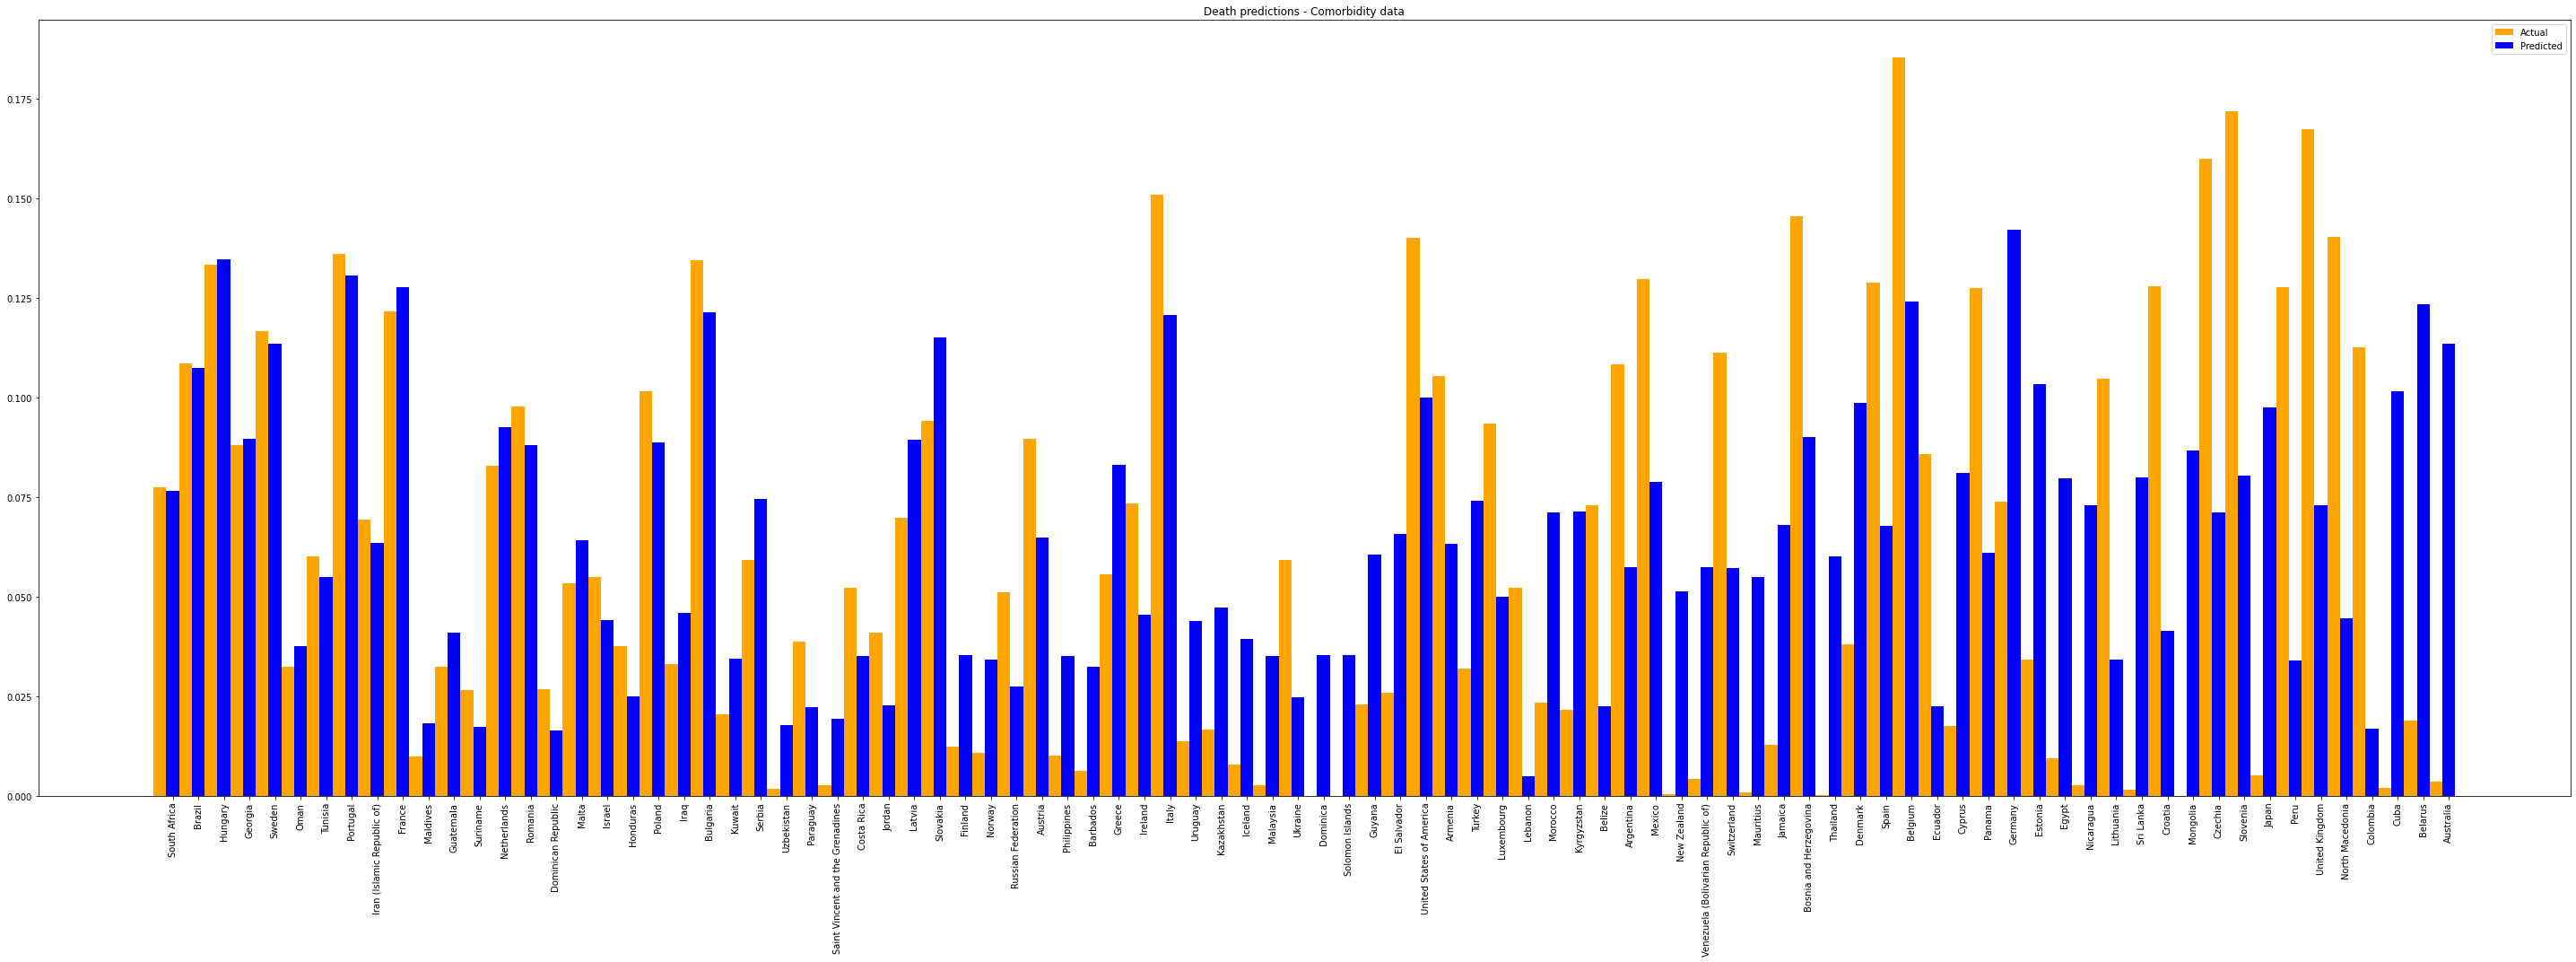

In [ ]:
x = np.arange(1, len(X_comorbidity) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.title('Death predictions - Comorbidity data')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.savefig('Death predictions comorbidity.png')

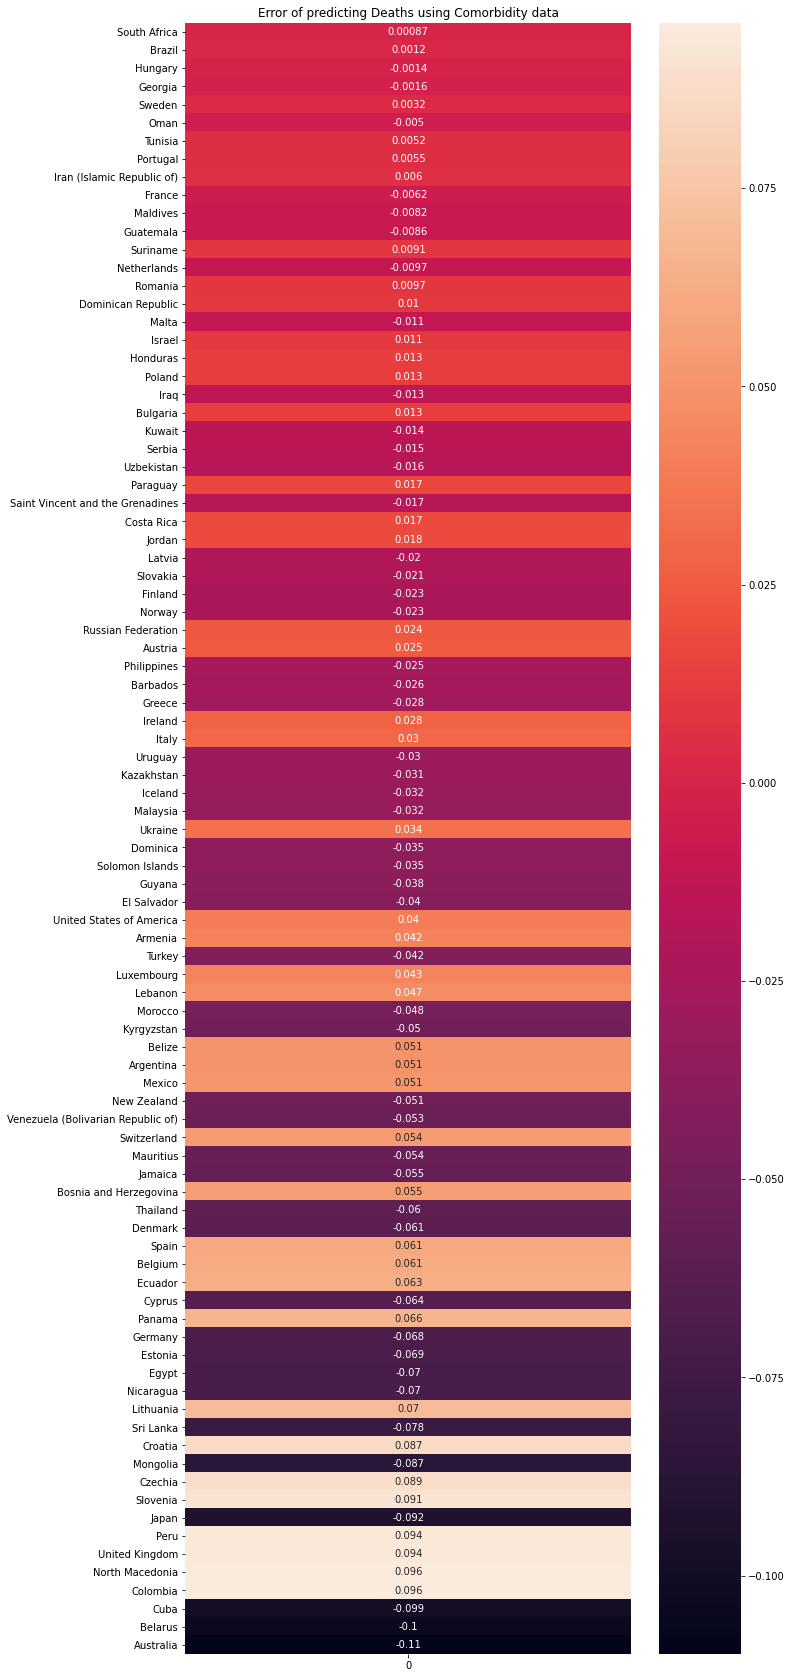

In [ ]:
errors_comorbidity = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_comorbidity = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_comorbidity, annot=True, yticklabels=countries_comorbidity)
plt.title("Error of predicting Deaths using Comorbidity data")
plt.savefig("Error of predicting Deaths using comorbidity data.png")